## Price Estimates

- Data Source: `Kaggle`

#### Tasks:
- **Cleansing**
- **EDA**
- **Merge Additional Data by geo/zip**
- **K-Means Clustering**
- **Model Price**

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split as SPLIT
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
df_raw = pd.read_csv('/Users/sandeepk/Desktop/_Spatial_/Final_575/WA_house_data.csv')
df_raw.head(2)

,OID_,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,1,7.129301e+09,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,2,6.414100e+09,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639


## Merge Additional Data
- `Zip` or `city` as **Primary Key**
- Crime Data, Population Data, etc.

In [3]:
#Population Data #ON QI DATA
zip_df = pd.read_csv('population_by_zip_2010.csv').groupby('zipcode')['population'].max().reset_index() 
df_raw = df_raw.merge(zip_df, left_on='zipcode', right_on='zipcode', how='left') #Relational Join
df_raw.drop(columns=['zipcode'], inplace=True)

## Cleansing
- Null Values + Outliers _`viz + stats`_

In [4]:
def dist_range(df, col, z): #Output z-score ranges for data distribution of feature
    upper = round(df[col].mean() + (df[col].std())*z,4)
    lower = round(df[col].mean() - (df[col].std())*z,4)
    if lower<0:lower=0
    print(f'{col.title()} {z} Z-scores of Data: ({lower},{upper})') 

In [5]:
dist_range(df_raw, 'bathrooms',3) #QI DATA
dist_range(df_raw, 'bedrooms',3)
dist_range(df_raw, 'sqft_living',3)
dist_range(df_raw, 'price',3)
dist_range(df_raw, 'price',2)

Bathrooms 3 Z-scores of Data: (0,4.4252)
Bedrooms 3 Z-scores of Data: (0.5807,6.161)
Sqft_Living 3 Z-scores of Data: (0,4835.2224)
Price 3 Z-scores of Data: (0,1641469.7312)
Price 2 Z-scores of Data: (0,1274342.5347)


In [6]:
#QI DATA # Remove Outliers in Analysis Columns
df = df_raw.query('bathrooms <=5 and bedrooms <=7 and sqft_living <= 4500 and price<1500000')

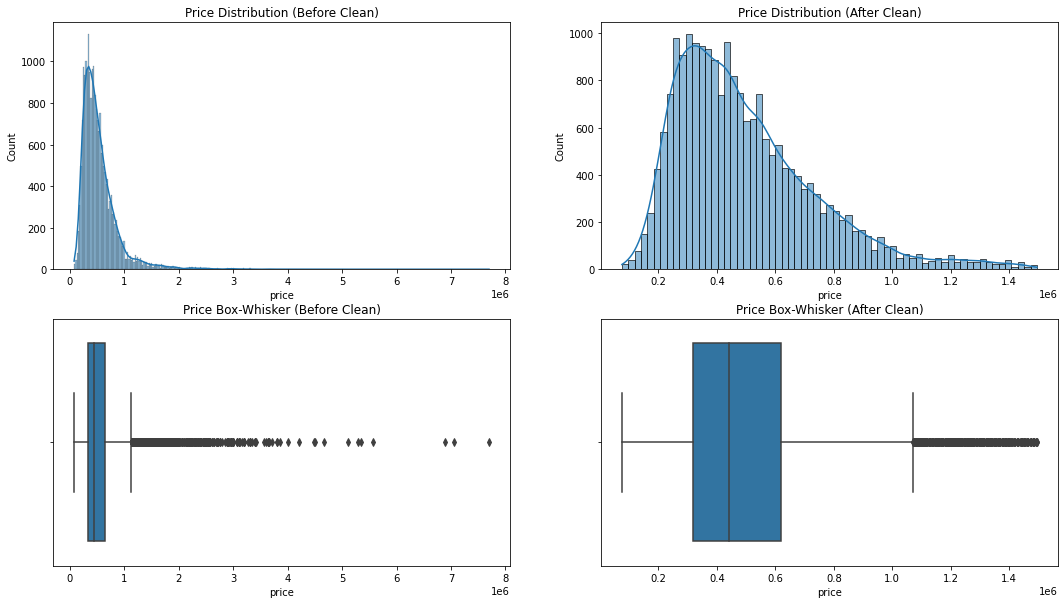

In [7]:
#QI DATA
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

axes[0,0].set_title('Price Distribution (Before Clean)')
sns.histplot(df_raw['price'], kde=True, ax=axes[0,0]);

axes[1,0].set_title('Price Box-Whisker (Before Clean)')
sns.boxplot(x=df_raw['price'],ax=axes[1,0]);

axes[0,1].set_title('Price Distribution (After Clean)')
sns.histplot(df['price'], kde=True, ax=axes[0,1]);

axes[1,1].set_title('Price Box-Whisker (After Clean)')
sns.boxplot(x=df['price'], ax=axes[1,1]);

In [8]:
pd.DataFrame(df.isnull().sum()).rename(columns={0:'Null_Count'})

,Null_Count
OID_,0
id,0
date,0
price,0
bedrooms,0
bathrooms,0
sqft_living,0
sqft_lot,0
floors,0
waterfront,0


In [ ]:
#Engineer Days since prev_sold and peep corr

## EDA
- _Univariate_ Analysis of Price
- _Bivariate_ Analysis
- Correlation
- Sig. Testing

#### Distributions, Correlation, Multidimensional Viz 

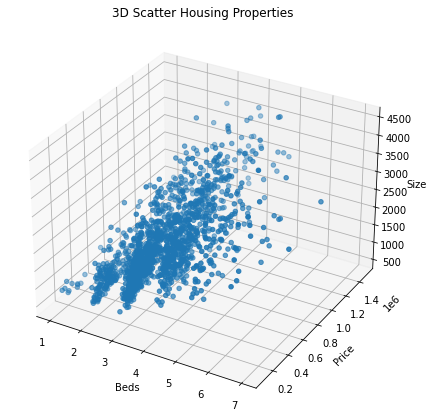

In [9]:
#QI DATA
fig = plt.figure(figsize=(7,9))
ax = plt.axes(projection = '3d') #3D scatter plot

sampled_df = df.sample(n=1500) #Sample df for Viz

ax.scatter(sampled_df['bedrooms'], sampled_df['price'], sampled_df['sqft_living'])

ax.set_xlabel('Beds')
ax.set_ylabel('Price')
ax.set_zlabel('Size')
ax.set_title('3D Scatter Housing Properties')
plt.show()

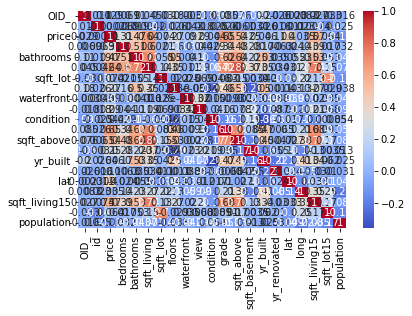

In [10]:
sns.heatmap(df.corr(), cmap='coolwarm', annot=True);

## K-means Clustering 

In [11]:
#Import Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 

In [12]:
df.reset_index(inplace=True)
df_k = df.copy() #df for K-means processes

### _Normalize Features_

In [13]:
df_k.head(2)

,index,OID_,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,population
0,0,1,7.129301e+09,20141013T000000,221900.0,3,1.00,1180,5650,1.0,...,7,1180,0,1955,0,47.5112,-122.257,1340,5650,24092
1,1,2,6.414100e+09,20141209T000000,538000.0,3,2.25,2570,7242,2.0,...,7,2170,400,1951,1991,47.7210,-122.319,1690,7639,37081


In [14]:
#QI DATA #Z-Scores 
scaler = StandardScaler()
df_k[['price_T', 'house_size_t', 'bath_t']] = scaler.fit_transform(df_k[['price', 'sqft_living', 'bathrooms']])

### _Elbow Function_

In [15]:
def elbow(data, max_k): #Identify optimal K value respecting SSE
    k_vals = []
    sse = []
    
    for k in range(1, max_k+1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        
        k_vals.append(k)
        sse.append(kmeans.inertia_)
        
    #Elbow Plot
    fig = plt.subplots(figsize=(10,5))
    plt.plot(k_vals, sse, 'o-')
    plt.xlabel('K')
    plt.ylabel('SSE')
    plt.grid(True)
    plt.show()

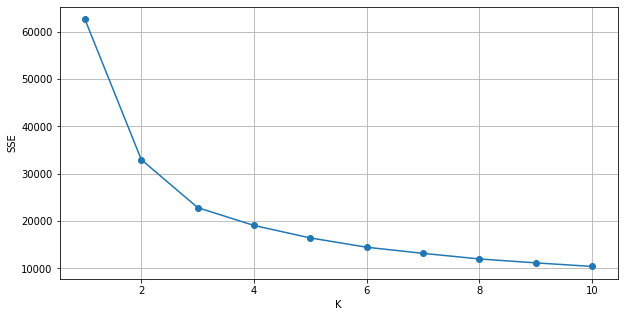

In [16]:
elbow(df_k[['price_T', 'house_size_t', 'bath_t']], 10) #QI DATA

## K-means application
- `k = 3`
- `vars = price, house_size, bathrooms`

In [17]:
#QI DATA
kmeans = KMeans(n_clusters=3) #Fit data to Kmeans Algo
kmeans.fit(df_k[['price_T', 'bath_t', 'house_size_t']])

KMeans(n_clusters=3)

In [18]:
df_k['kmeans_3_multi'] = kmeans.labels_ #Labels added to df

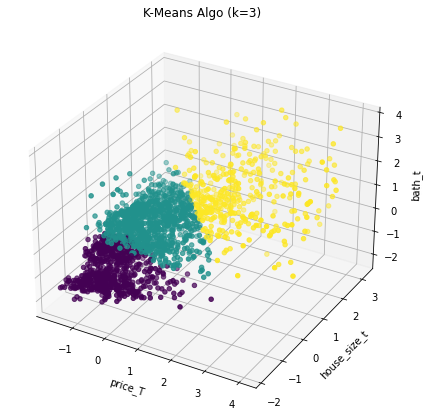

In [24]:
#QI DATA
fig = plt.figure(figsize=(7,9))
ax = plt.axes(projection = '3d') #3D scatter plot

df_k_sampled = df_k.sample(2000, random_state=100) #Sample df for Viz

ax.scatter(df_k_sampled['price_T'], df_k_sampled['house_size_t'], df_k_sampled['bath_t'], c=df_k_sampled['kmeans_3_multi'])

ax.set_xlabel('price_T')
ax.set_ylabel('house_size_t')
ax.set_zlabel('bath_t')
ax.set_title('K-Means Algo (k=3)')
plt.show()

## Modeling Tasks